In [4]:
import pandas as pd
import numpy as np

from dython import nominal
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup

import nltk
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
nltk.download('stopwords')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers

from scipy.sparse import hstack

from tokenizers import Tokenizer


# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/olivierlambertrouillard/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
df = pd.read_csv('../../data/tweets_one_hot.csv')
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4807 entries, 0 to 4806
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   date     4807 non-null   object
 1   line     4807 non-null   object
 2   tweet    4807 non-null   object
 3   stop     4807 non-null   int64 
 4   restart  4807 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 187.9+ KB
None


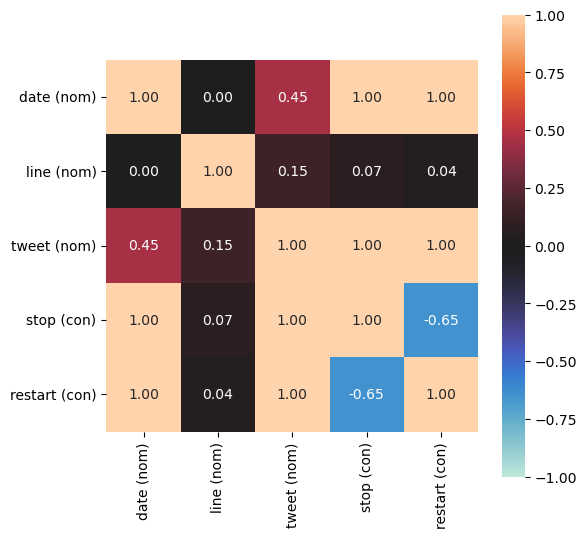

{'corr':                date (nom)  line (nom)  tweet (nom)  stop (con)  restart (con)
 date (nom)       1.000000    0.000000     0.454786    0.999571       1.000000
 line (nom)       0.000000    1.000000     0.149119    0.071620       0.041988
 tweet (nom)      0.454786    0.149119     1.000000    1.000000       1.000000
 stop (con)       0.999571    0.071620     1.000000    1.000000      -0.646948
 restart (con)    1.000000    0.041988     1.000000   -0.646948       1.000000,
 'ax': <Axes: >}

In [6]:
#CORRELATION COEFFICIENTS
nominal.associations(df, figsize=(6,6),mark_columns=True)

In [7]:
print(df.stop.value_counts())
print(df.restart.value_counts())

stop
1    2816
0    1991
Name: count, dtype: int64
restart
0    3678
1    1129
Name: count, dtype: int64


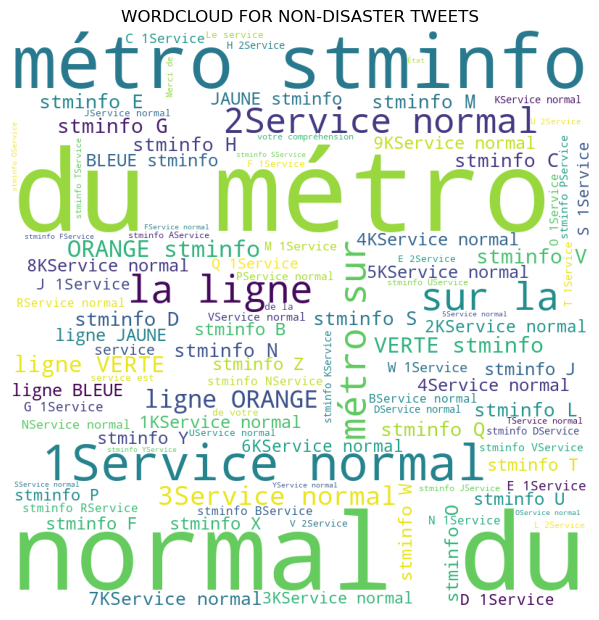

In [8]:
#WORDCLOUD FOR NON-DISASTER TWEETS
all_txt = ' '

for tweet in df["tweet"][df["restart"]==1]:
    all_txt += tweet

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(all_txt)
  
# plot the WordCloud image                       
plt.figure(figsize = (6,6), facecolor = None)
plt.title("WORDCLOUD FOR NON-DISASTER TWEETS")
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
  
plt.show()

In [9]:
string = "Aujourd’hui, le métro de Montréal célèbre ses 50 ans! Joignez-vous à nous en cette journée spéciale de célébrations!  http://ow.ly/QDXE305b24y http://"

string.split()
# sw = set(stopwords.words('english'))

['Aujourd’hui,',
 'le',
 'métro',
 'de',
 'Montréal',
 'célèbre',
 'ses',
 '50',
 'ans!',
 'Joignez-vous',
 'à',
 'nous',
 'en',
 'cette',
 'journée',
 'spéciale',
 'de',
 'célébrations!',
 'http://ow.ly/QDXE305b24y',
 'http://']

In [17]:
df = pd.read_csv('../../data/tweets_one_hot.csv')
def remove_short_word(tweet):
    tweet_ = []
    for word in tweet.split():
        if len(word) < 4:
            continue
            
        tweet_.append(word)

    return " ".join(tweet_)

#Character job
df.tweet = (df.tweet.str.lower()
    ).replace("l’", "", regex=True
    ).replace("-", " ", regex=True
    ).replace("[éèêë]", "e", regex=True
    ).replace("[ç]", "c", regex=True
    ).replace("[àâ]", "a", regex=True
    ).replace("[îï]", "i", regex=True
    ).replace("[ûùü]", "u", regex=True
    ).replace('http?\:\/\/\S*', "", regex=True
    ).replace('^@\S*', "", regex=True
    ).replace('[^A-Za-z\s]', "", regex=True
    ).replace('stminfo', "", regex=True
    ).replace('ligne verte', "ligne", regex=True
    ).replace('ligne orange', "ligne", regex=True
    ).replace('ligne jaune', "ligne", regex=True
    ).replace('ligne bleue', "ligne", regex=True
    )

#Remove short word
df.tweet = df.tweet.apply(remove_short_word)

#Remove english
sw = stopwords.words('english')
swe = set(stopwords.words('english'))
swf = set(stopwords.words('french'))
swe = swe.difference(swf)

def sw_in(tweet):
    for word in tweet.split():
        #exeception
        if word in ['show']:
            continue
            
        if word in swe:
            return True
        
    return False

,date,line,tweet,stop,restart
0,2016-10-14 07:14:30-04:00,stm_Jaune,aujourdhui metro montreal celebre joignez vous...,0,0
1,2016-10-19 05:40:59-04:00,stm_Jaune,arret ligne entre longueuil berri uqam personn...,1,0
2,2016-10-19 05:53:36-04:00,stm_Jaune,service normal metro,0,1
3,2016-11-15 14:25:53-05:00,stm_Jaune,arret ligne entre longueuil berri uqam problem...,1,0
4,2016-11-15 14:54:26-05:00,stm_Jaune,service normal metro ligne,0,1
...,...,...,...,...,...
4802,2024-04-02 13:39:59-04:00,stm_Verte,service normal metro,0,1
4803,2024-04-03 17:56:42-04:00,stm_Verte,interruption service ligne entre viau beaugran...,1,0
4804,2024-04-03 18:10:40-04:00,stm_Verte,interruption service prolongee ligne entre via...,1,0
4805,2024-04-03 18:20:34-04:00,stm_Verte,reprise graduelle service ligne,1,0


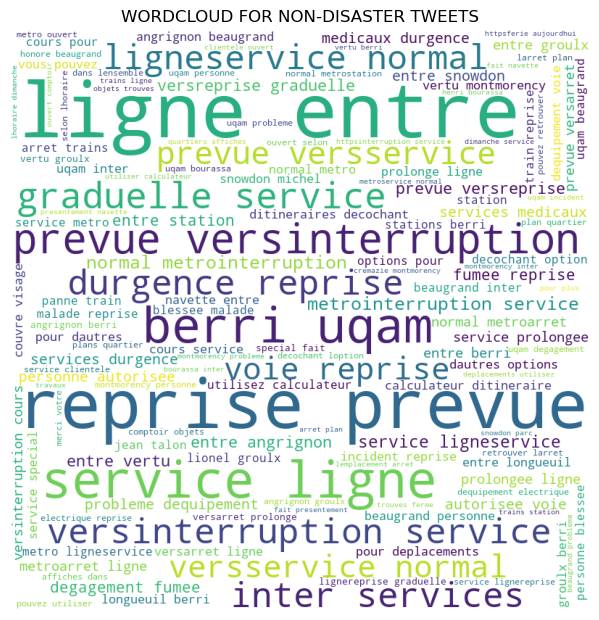

In [18]:
#WORDCLOUD FOR NON-DISASTER TWEETS
all_txt = ' '

for tweet in df.tweet:
    all_txt += tweet

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(all_txt)
  
# plot the WordCloud image                       
plt.figure(figsize = (6,6), facecolor = None)
plt.title("WORDCLOUD FOR NON-DISASTER TWEETS")
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
  
plt.show()

In [11]:
#Train test
X_train, X_test, y_train, y_test = train_test_split(df.tweet.values, df.stop.values, random_state=42)

In [12]:
#tfidf with unigrams
tfidf_txt_uni = TfidfVectorizer(ngram_range= (1,1))
tfidf_txt_uni.fit(X_train)

xtr_txt_vec = tfidf_txt_uni.transform(X_train)
xcv_txt_vec = tfidf_txt_uni.transform(X_test)
print ("shape of tfidf vectors:",xtr_txt_vec.shape, xcv_txt_vec.shape)

shape of tfidf vectors: (3605, 1842) (1202, 1842)


# DEEP LEARNING

In [13]:
tok = tf.keras.preprocessing.text.Tokenizer()
tok.fit_on_texts(df.tweet.values)
vocab_size = len(tok.word_index) + 1
vocab_size

xtr_enc = tok.texts_to_sequences(X_train)
xte_enc = tok.texts_to_sequences(X_test)

def len_of_tweet(tweet):
     return len(tweet.split())

max_length = df.tweet.apply(len_of_tweet).max()
xtr_enc_p = pad_sequences(xtr_enc, maxlen=max_length, padding = 'post')
xte_enc_p = pad_sequences(xte_enc, maxlen=max_length, padding = 'post')

In [14]:
#Creating embedding matrix for embedding layer
#https://keras.io/examples/nlp/pretrained_word_embeddings/ (reference)
#https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/ (reference)
hits = 0
miss = 0
emb_mat = np.zeros((vocab_size,300))
# for word,n in tok.word_index.items():
#     emb_vec = gv.get(word)
#     if emb_vec is not None:
#         emb_mat[n]=emb_vec
#         hits += 1
#     else:
#         miss += 1
# print("Converted %d words (%d misses)" % (hits, miss))


In [15]:
#defining the architecture
tf.keras.backend.clear_session()
model = tf.keras.Sequential()
model.add(layers.Input(shape=(max_length,)))
model.add(layers.Embedding(vocab_size, 300, embeddings_initializer=tf.keras.initializers.Constant(emb_mat), trainable=True))
model.add(layers.Bidirectional(layers.LSTM(64, return_sequences=True)))


model.add(layers.Flatten())
model.add(layers.Dense(1, activation='sigmoid'))
# model.summary()

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),optimizer='adam', metrics=['accuracy'])

epochs = 10
model.fit(xtr_txt_vec, batch_size=32, validation_split=.1, epochs=epochs)

# in_layer = tf.keras.Input(shape=(max_length,))
# emb_layer = Embedding(vocab_size,300,embeddings_initializer=tf.keras.initializers.Constant(emb_mat),trainable=False)(in_layer)
# lstm1 = Bidirectional(LSTM(64,return_sequences=True))(emb_layer)
# dp1 = Dropout(0.2)(lstm1)
# lstm2 = Bidirectional(LSTM(32,return_sequences=True))(dp1)
# dp2 = Dropout(0.2)(lstm2)
# lstm3 = Bidirectional(LSTM(16,return_sequences=True))(dp2)
# dp3 = Dropout(0.2)(lstm3)
# fc1 = Dense(64,activation='relu',kernel_initializer=tf.keras.initializers.HeNormal(seed=40))(dp3)
# dp4 = Dropout(0.1)(fc1)
# fc2 = Dense(32,activation='relu',kernel_initializer=tf.keras.initializers.HeNormal(seed=45))(dp4)
# dp5 = Dropout(0.1)(fc2)
# flat = Flatten()(dp5)
# out_layer = Dense(1,activation='sigmoid')(flat)
# #model creation
# model3 = Model(inputs=in_layer,outputs=out_layer)
# model3.summary()

Epoch 1/10


ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense" is incompatible with the layer: expected axis -1 of input shape to have value 7936, but received input with shape (None, 235776)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 1842), dtype=float32)
  • training=True
  • mask=None

In [43]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

max_words = 1000
max_len = 50
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df.tweet.values)
sequences = tokenizer.texts_to_sequences(df.tweet.values)
X_processed = pad_sequences(sequences, maxlen=max_len)
X_processed

array([[  0,   0,   0, ..., 116, 152, 687],
       [  0,   0,   0, ...,   3,   6,   5],
       [  0,   0,   0, ...,   1,   9,   7],
       ...,
       [  0,   0,   0, ...,   3,   6,   5],
       [  0,   0,   0, ...,  16,   1,   2],
       [  0,   0,   0, ...,   1,   9,   7]], dtype=int32)

In [30]:
model = Sequential()
model.add(Embedding(max_words, 32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X_processed, df.stop.values, test_size=0.2, random_state=42)
X_train_, X_test_, y_train_, y_test_ = train_test_split(df.tweet.values, df.stop.values, test_size=0.2, random_state=42)
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 5.3615e-04 - val_accuracy: 0.9922 - val_loss: 0.0357
Epoch 2/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 4.6628e-04 - val_accuracy: 0.9922 - val_loss: 0.0354
Epoch 3/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 3.4104e-04 - val_accuracy: 0.9922 - val_loss: 0.0401
Epoch 4/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 3.0835e-04 - val_accuracy: 0.9922 - val_loss: 0.0384
Epoch 5/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 2.6028e-04 - val_accuracy: 0.9922 - val_loss: 0.0408
Epoch 6/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 2.3713e-04 - val_accuracy: 0.9922 - val_loss: 0.0402
Epoch 7/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 2.0260e-04 - val_accuracy: 0.9935 - val_loss: 0.0403
Epoch 8/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 1.8216e-04 - 

In [32]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {accuracy}')

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9959 - loss: 0.0097     
Test accuracy: 0.9927234649658203


In [55]:
for i in range(10):
    print(X_test_[i])
    print(model.predict(X_test[i].reshape(1, -1)), y_test_[i])

arret prolonge ligne entre groulx berri uqam infiltration deau reprise prevue vers
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
[[0.99993783]] 1
service normal metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
[[9.941195e-05]] 0
service normal metro ligne
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
[[0.00019544]] 0
station vendme lundi jusqua aout boucle sera fermee pour realiser travaux lien avec nouvel edicule arrets trouvent seront relocalises boulevard maisonneuve infos
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
[[0.00014787]] 0
service normal metro ligne
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
[[0.00019544]] 0
station mcgill travaux refection station causant fermeture boul maisonneuve debuteront lundi mars certains arrets lignes devront etre deplaces details
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
[[0.0002403]] 0
reprise graduelle service ligne
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
[[0.99984115]] 1
arret prolonge ligne entre berri uqam frontenac incident duree indeterminee
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
[[0.